# PongDeterministic REINFORCE
Train an agent to play pong using only the pixels as inputs.


In [1]:
# Import the Necessary Packages
import ale_py
import gymnasium as gym
from parallelEnv import parallelEnv 
# import numpy as np
# Initialize pong environment
env = gym.make('PongDeterministic-v4') # Here, used Determistic version which does not contains random frame skippipng. Therefore, it's less noise and makes it a little easier to train


# Explore state (observation) space
# print("State space: ", env.observation_space)
print("State shape: ", env.observation_space.shape)

# # Explore the action space
print("Action space:", env.action_space)
print("Action shape:", env.action_space.shape)


print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# This way it will keep our policies simple. Therefore, our policy will just 
# output the probabilit of going to the right, such that the probabilit of going left
# is just one minus that.
# so only be using these two actions here.
# the 'FIRE' part ensures that the game starts again after losing a life


State shape:  (210, 160, 3)
Action space: Discrete(6)
Action shape: ()
List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


# preprocessing
Here, we are only using the pixels as input, it will be advantageous for us to preprocess the image to keep the input a little smaller. That also speed up training.

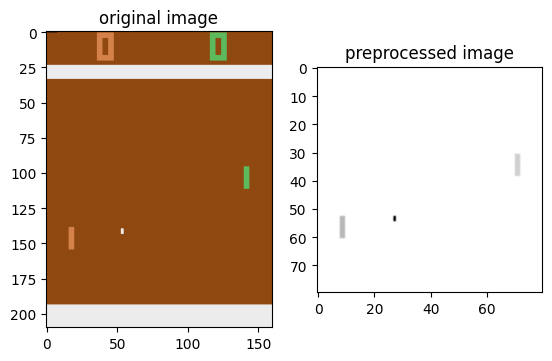

In [2]:
# Import the Necessary Packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# show what a preprocessed image looks like
env.reset()
pack = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(1)
    
# preprocess a single frame
# crop image and downsample to 80x80
# stack two frames together as input
# we down-sample the image. make it balck and white, and also crop the 
# boundaries that are irrelevant
def preprocess_single(image, bkg_color=np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2, ::2]-bkg_color, axis=-1)/255.
    return img

plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(preprocess_single(frame), cmap='Greys')
plt.title('preprocessed image')

plt.show()

# Policy
Implement policy:

The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

Modify neural network:
* 80x80 to outputsize x outputsize
* outputsize = (inputsize - kernel_size + stride)/stride 
* (round up if not an integer)
* Keep tract output dimension for case `output_dim = (W-F+2P)/S + 1`

In [3]:
# Import the Necessary Packages
import torch
import torch.nn as nn
import torch.nn.functional as F

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        # (80-6)/2 +1 =38  --> 38x38x4
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        # (38-6)/4 +1 = 0 ---> 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Simulate game and display animation


In [5]:
RIGHT=4
LEFT=5
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display # <-----add
from matplotlib import animation
import random as rand
# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color, axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

# add display_animation here-----------------------------
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())
# -----------------------------------------------

# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
#     display(display_animation(fanim, default_mode='once')) #<----remove
    display(display_animation(fanim)) # <--------------------------add
    
# play a game and display the animation
# nrand = number of random steps before using the policy
def play(env, policy, time=2000, preprocess=None, nrand=5):
    env.reset()

    # star game
    env.step(1)
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, _, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, _, _ = env.step(0)
    
    anim_frames = []
    
    for _ in range(time):
        
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
        
        # RIGHT = 4, LEFT = 5
        action = RIGHT if rand.random() < prob else LEFT
        frame1, _, is_done, _, _ = env.step(action)
        frame2, _, is_done, _, _ = env.step(0)

        if preprocess is None:
            anim_frames.append(frame1)
        else:
            anim_frames.append(preprocess(frame1))

        if is_done:
            break
    
    env.close()
    
    animate_frames(anim_frames)
    return 



In [6]:
play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [7]:
import numpy as np
import torch
import torch.optim as optim
envs = parallelEnv('PongDeterministic-v4', n=1, seed=12345)


# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    
    # number of parallel instances
    n=len(envs.ps)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()
    
    # start all parallel agents
    envs.step([1]*n)
    
    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):

        # prepare the input
        # preprocess_batch properly converts two frames into 
        # shape (n, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = preprocess_batch([fr1,fr2])
        
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        
        
        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2
        
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, action_list, reward_list


prob, state, action, reward = collect_trajectories(envs, policy, tmax=100)

In [8]:
print(reward)

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([-1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([-1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([-1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0

# Function Definitions
Here you will define key functions for training. 

(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [9]:
import numpy as np
import torch
RIGHT=4
LEFT=5

# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

# return sum of log-prob divided by T
# same thing as -policy_loss
def surrogate(policy, old_probs, states, actions, rewards, discount = 0.995, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    # apply reward Normalization:
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10) + (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)



In [10]:
Lsur= surrogate(policy, prob, state, action, reward)
print(Lsur)

tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)


/tmp/ipykernel_2462658/1307840496.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/torch/csrc/utils/tensor_new.cpp:278.)
  actions = torch.tensor(actions, dtype=torch.int8, device=device)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [11]:
from parallelEnv import parallelEnv
import numpy as np
import torch
import time
import torch.optim as optim
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # use surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=1208fc318d887f492be29b1c3f5c6977a42e685b6bdf36ff7122c6cd47859bf7
  Stored in directory: /home/yangyifei/.cache/pip/wheels/d7/d9/89/a3f31c76ff6d51dc3b1575628f59afe59e4ceae3f2748cd7ad
Successfully built progressbar


KeyboardInterrupt: 

In [ ]:
# play game after training!
play(env, policy, time=2000) 

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')